In [1]:
import matplotlib.pyplot as plt

# Simple utility function to display image comparisons
def side_by_side(left, right):
    plt.figure(figsize=(15, 10))

    plt.subplot(121)
    plt.imshow(left)

    plt.subplot(122)
    plt.imshow(right)
    
    plt.show()

## Camera Calibration

In [2]:
from glob import glob
import numpy as np
import cv2

object_points = []
image_points = []
for pathname in glob('camera_cal/*.jpg'):
    image = cv2.imread(pathname, cv2.IMREAD_GRAYSCALE)
    ret, corners = cv2.findChessboardCorners(image, (9, 6))
    
    # Check if all corners have been detected
    if ret == 0: continue
    
    object_points.append([
        [0., 0., 0.], [8., 0., 0.],
        [0., 5., 0.], [8., 5., 0.],
    ])
    
    image_points.append([
        corners[0][0], corners[8][0], 
        corners[45][0], corners[53][0]
    ])

object_points = np.array(object_points, dtype=np.float32)
image_points = np.array(image_points, dtype=np.float32)
    
ret, cmtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image.shape[::-1], None, None)

### Undistort test image

To validate if the calibration has been conducted properly, we will undistort a single example image.

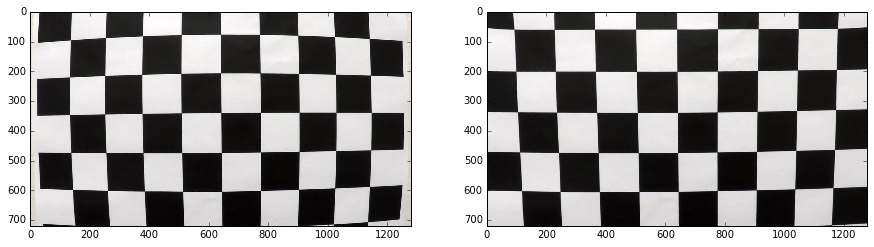

In [3]:
test_image = cv2.imread('camera_cal/calibration1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(test_image, cmtx, dist)

side_by_side(test_image, undistorted)